In [1]:
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc
import matplotlib.pyplot as plt
import seaborn as sm
import yfinance as yf

#Facebook Prophet packages:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Time Series Forecasting with Prophet

In [4]:
data = yf.download("BTC-USD", start="2012-01-01", end="2022-10-01")

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-09-26,18803.900391,19274.873047,18721.285156,19222.671875,19222.671875,4.414880e+10
2022-09-27,19221.839844,20338.455078,18915.667969,19110.546875,19110.546875,5.857144e+10
2022-09-28,19104.621094,19688.343750,18553.296875,19426.720703,19426.720703,5.307130e+10
2022-09-29,19427.779297,19589.265625,18924.353516,19573.050781,19573.050781,4.103784e+10
2022-09-30,19573.431641,20109.849609,19265.662109,19431.789062,19431.789062,4.397525e+10


20:45:14 - cmdstanpy - INFO - Chain [1] start processing
20:45:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,Delta
3081,2023-02-23,23599.253079,16420.899378,31209.136333,52.615680
3082,2023-02-24,23543.417409,15847.162313,31361.958831,50.529887
3083,2023-02-25,23510.966767,16688.349283,30914.951291,53.981483
3084,2023-02-26,23425.403254,16330.673141,31030.219439,52.628288
3085,2023-02-27,23362.310959,16286.540236,30852.969396,52.787594


,ds,yhat_lower,yhat_upper,weekly_lower,weekly_upper,yhat,Real
3081,2023-02-23,16420.899378,31209.136333,-25.632632,-25.632632,23599.253079,NaN
3082,2023-02-24,15847.162313,31361.958831,-20.739640,-20.739640,23543.417409,NaN
3083,2023-02-25,16688.349283,30914.951291,14.735859,14.735859,23510.966767,NaN
3084,2023-02-26,16330.673141,31030.219439,2.585373,2.585373,23425.403254,NaN
3085,2023-02-27,16286.540236,30852.969396,16.585526,16.585526,23362.310959,NaN


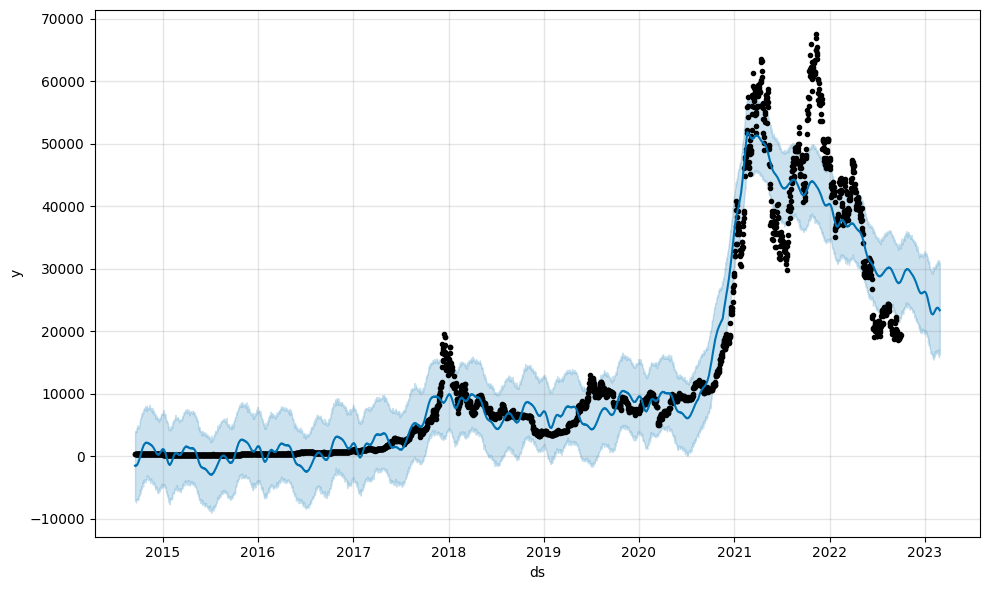

In [5]:
data=data.reset_index()

## Grouping the time from minutes to Hours
data['Date'] = data['Date'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
data = data.set_index('Date')

# Since we are working with time series and we have dates as index
# We decided that --Interpolation, would be the best usage -- When we use neighboring data points to estimate the missing value. 
# Interpolation can also be a form of imputation.
 
data['Close']=data['Close'].interpolate( method='time', axis=0)
data['Open']=data['Open'].interpolate( method='time', axis=0)
data['High']=data['High'].interpolate( method='time', axis=0)
data['Low']=data['Low'].interpolate( method='time', axis=0)

data.tail()

df = data.copy()
# Resampling to daily frequency
df_day = df.resample('D').mean()
# Resampling to monthly frequency
df_week = df.resample('W').mean()
# Resampling to monthly frequency
df_month = df.resample('M').mean()
# Resampling to quarterly frequency
df_quarter = df.resample('Q-DEC').mean()
# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

df.tail()

# basically creating a range that includes all data
start = '2014-01-01'
end = '2022-10-01'

# find rows between start and end time 
df_day = df_day[(df_day.index >= start) & (df_day.index <= end)]
df_week = df_week[(df_week.index >= start) & (df_week.index <= end)]
df_month = df_month[(df_month.index >= start) & (df_month.index <= end)]
df_quarter = df_quarter[(df_quarter.index >= start) & (df_quarter.index <= end)]
df_year = df_year[(df_year.index >= start) & (df_year.index <= end)]

display(df_day.tail())
print("\n")

# Renaming the column names accroding to Prophet's requirements
prophet_df = df_day.reset_index()[['Date','Close']]
prophet_df.rename(columns={'Date':'ds','Close':'y'},inplace=True)
prophet_df.tail()

pro_regressor = Prophet()
pro_regressor.fit(prophet_df)

# Python
future = pro_regressor.make_future_dataframe(periods=150)
future.tail()

# Python
forecast = pro_regressor.predict(future)
forecast['Delta'] = (forecast['yhat_lower']/forecast['yhat_upper'])*100
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','Delta']].tail())

# Python
fig1 = pro_regressor.plot(forecast)


csv = forecast[['ds', 'yhat_lower', 'yhat_upper', 'weekly_lower', 'weekly_upper', 'yhat']]
csv['Real'] = df_day.reset_index()['Close']
display(csv.tail())
print("\n")


from pathlib import Path  
filepath = Path('bitcoin_2023_prediction.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
csv.to_csv(filepath)  

In [6]:
df_cv = cross_validation(pro_regressor, initial='100 days', period='180 days', horizon = '365 days')
pm = performance_metrics(df_cv, rolling_window=0.1)
display(pm.head(),pm.tail())

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

20:45:29 - cmdstanpy - INFO - Chain [1] start processing
20:45:29 - cmdstanpy - INFO - Chain [1] done processing
20:45:29 - cmdstanpy - INFO - Chain [1] start processing
20:45:29 - cmdstanpy - INFO - Chain [1] done processing
20:45:30 - cmdstanpy - INFO - Chain [1] start processing
20:45:30 - cmdstanpy - INFO - Chain [1] done processing
20:45:31 - cmdstanpy - INFO - Chain [1] start processing
20:45:31 - cmdstanpy - INFO - Chain [1] done processing
20:45:31 - cmdstanpy - INFO - Chain [1] start processing
20:45:32 - cmdstanpy - INFO - Chain [1] done processing
20:45:32 - cmdstanpy - INFO - Chain [1] start processing
20:45:33 - cmdstanpy - INFO - Chain [1] done processing
20:45:33 - cmdstanpy - INFO - Chain [1] start processing
20:45:34 - cmdstanpy - INFO - Chain [1] done processing
20:45:34 - cmdstanpy - INFO - Chain [1] start processing
20:45:34 - cmdstanpy - INFO - Chain [1] done processing
20:45:35 - cmdstanpy - INFO - Chain [1] start processing
20:45:36 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,3.984756e+07,6312.492632,3149.103484,0.242062,0.231385,0.277734,0.275930
1,38 days,3.980855e+07,6309.402073,3176.084151,0.245296,0.238773,0.281795,0.274951
2,39 days,3.946692e+07,6282.270200,3196.810921,0.248426,0.238773,0.285626,0.275930
3,40 days,3.924553e+07,6264.624969,3220.642694,0.251505,0.239934,0.289519,0.272994
4,41 days,3.896612e+07,6242.284685,3245.594867,0.254820,0.241636,0.293584,0.270059


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
324,361 days,5.844432e+08,24175.260417,15545.283824,1.142524,0.763401,1.092414,0.142857
325,362 days,5.870947e+08,24230.037853,15570.912328,1.142149,0.764402,1.093416,0.142857
326,363 days,5.891502e+08,24272.417069,15586.445927,1.141387,0.768084,1.094105,0.142857
327,364 days,5.908302e+08,24306.999673,15597.709018,1.140503,0.769494,1.094736,0.142857
328,365 days,5.934198e+08,24360.209321,15619.589871,1.139767,0.770831,1.095584,0.142857


# -------------------------------------------------------------------------------------

In [17]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

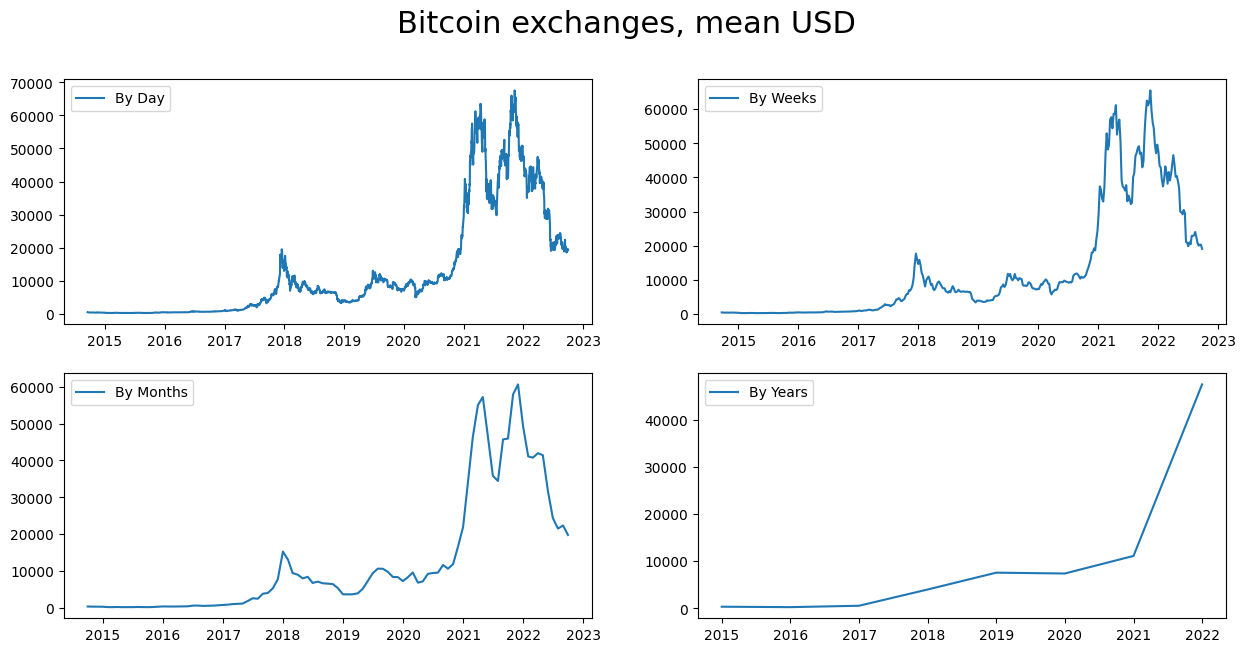

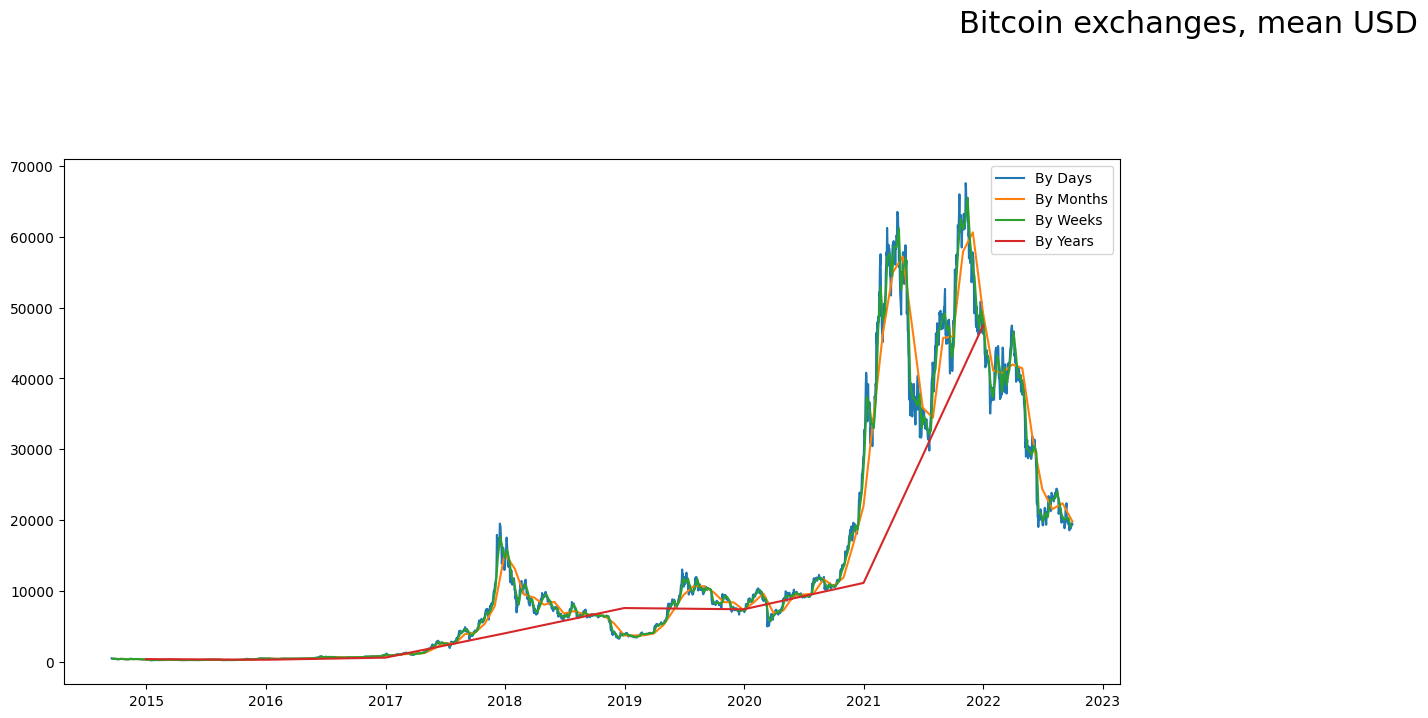

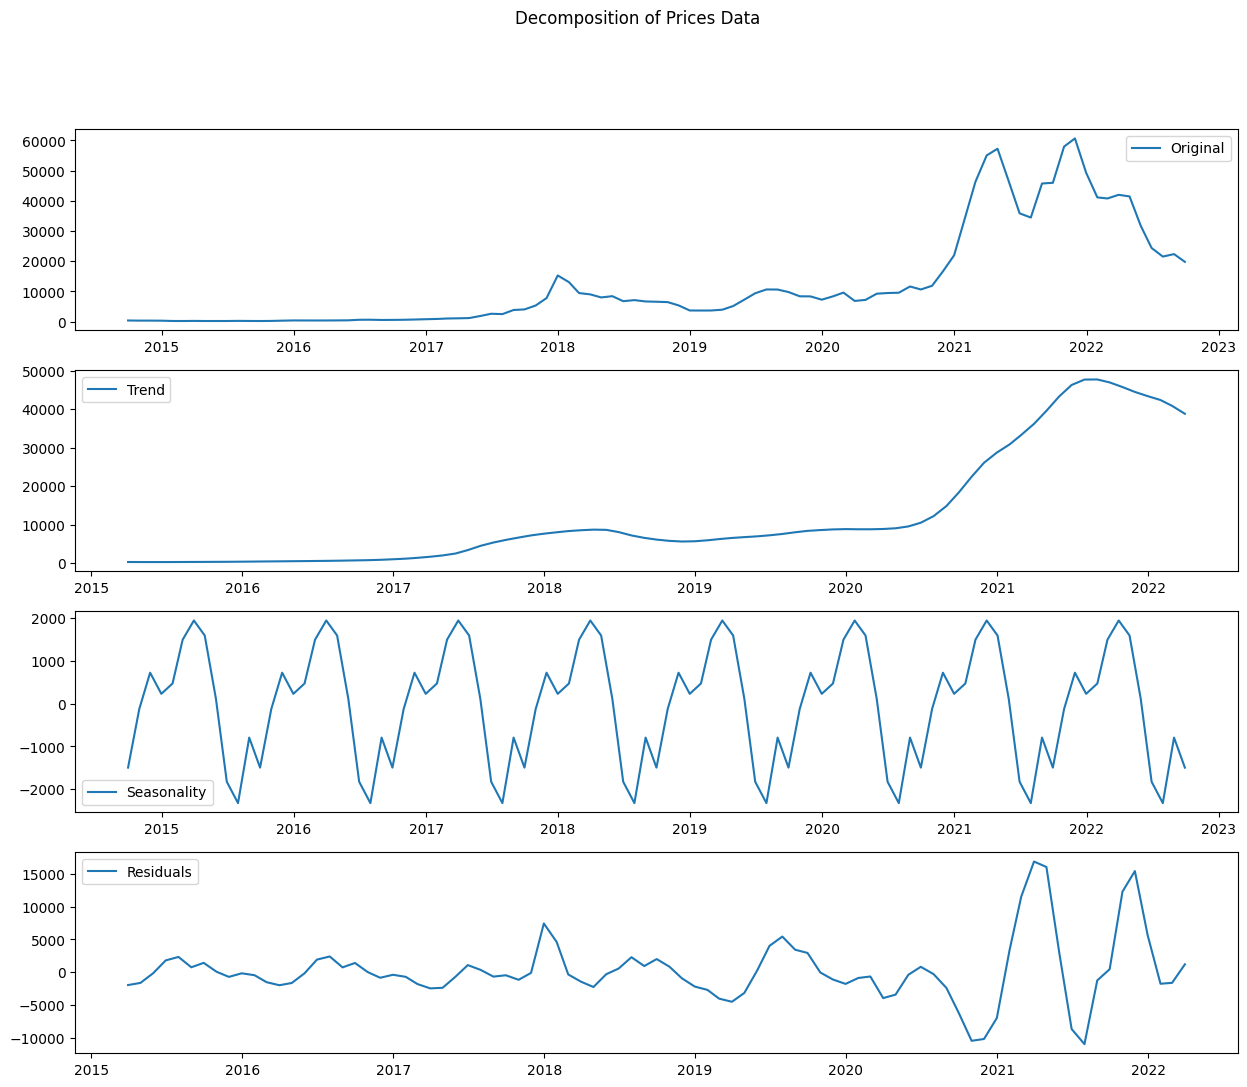

Change points:  {prophet_basic.changepoints}



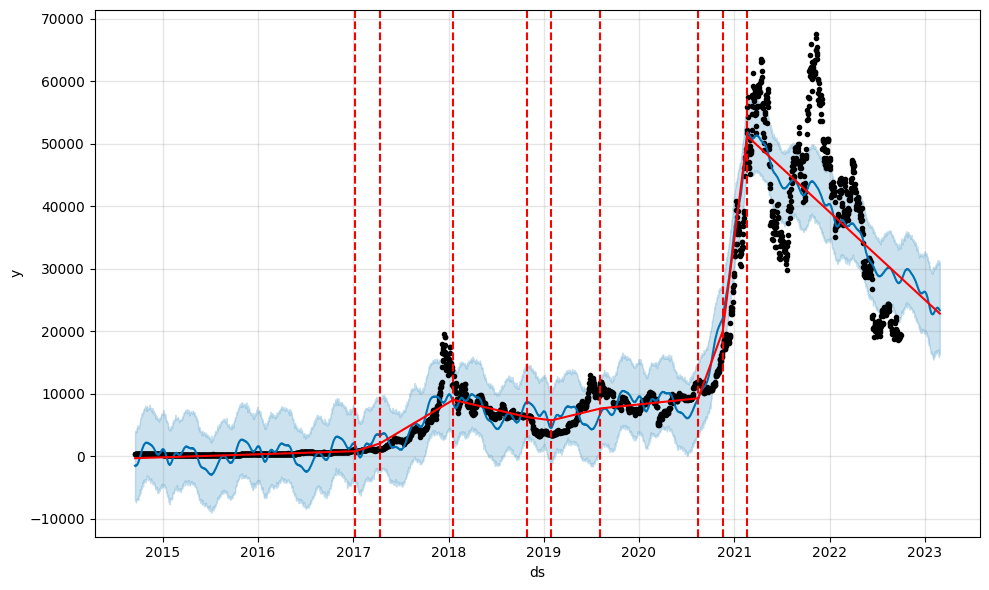

In [18]:
####### PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)
plt.subplot(221)
plt.plot(df_day.Close, '-', label='By Day')
plt.legend()
plt.subplot(222)
plt.plot(df_week.Close, '-', label='By Weeks')
plt.legend()
plt.subplot(223)
plt.plot(df_month.Close, '-', label='By Months')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Close, '-', label='By Years')
plt.legend()
plt.show()

####### PLOTS
fig = plt.figure(figsize=[30, 15])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)
plt.subplot(221)
plt.plot(df_day.Close, '-', label='By Days')
plt.legend()
plt.subplot(221)
plt.plot(df_month.Close, '-', label='By Months')
plt.legend()
plt.subplot(221)
plt.plot(df_week.Close, '-', label='By Weeks')
plt.legend()
plt.subplot(221)
plt.plot(df_year.Close, '-', label='By Years')
plt.legend()

plt.show()


####### PLOTS
decomposition = sm.tsa.seasonal_decompose(df_month.Close)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(15,12))
plt.subplot(411)
plt.plot(df_month.Close, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
fig.suptitle('Decomposition of Prices Data')
plt.show()

####### PLOTS
fig_1 = pro_regressor.plot(forecast)
a = add_changepoints_to_plot(fig_1.gca(), pro_regressor, forecast)

print('Change points: ','{prophet_basic.changepoints}\n')